In [1]:
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

c:\Users\maret\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ---------------------------------------------------------
# 1. DESCARGA DE DATOS (Actualizada con margen extra)
# ---------------------------------------------------------
print("Verificando archivos de datos...")
try:
    # Altura de ola (Misma config)
    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
        variables=["VHM0"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,     # Ampliado un poco al norte (21)
        start_datetime="2025-08-15T21:00:00",
        end_datetime="2025-08-22T21:00:00",
        output_filename="AlturaOla.nc",
        force_download=True 
    )

    # Corrientes (Dato diario P1D)
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
        variables=["ugos", "vgos"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,
        start_datetime="2025-08-15T00:00:00",
        end_datetime="2025-11-22T00:00:00",
        output_filename="Corrientes.nc",
        force_download=True
    )
    print("Datos listos.")
except Exception as e:
    print(f"Nota sobre descarga: {e}")

print("Descarga completada (o archivos ya existentes).")


In [34]:
# ---------------------------------------------------------
# 2. CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)
# ---------------------------------------------------------
print("\n--- Generando Semillas de Inicio ---")

# Lista para guardar las partículas. 
# Cada partícula será un diccionario con sus listas de historial.
particulas = []

# Definir puntos específicos
puntos_fijos = [
    {"lat": 20.0, "lon": -72.0, "label": "Punto N-O (20N, 72W)"},
    {"lat": 17.0, "lon": -72.0, "label": "Punto S-O (17N, 72W)"},
    {"lat": 20.0, "lon": -70.0, "label": "Punto S-O (20N, 70W)"}
]

# Agregar puntos fijos a la lista
for p in puntos_fijos:
    particulas.append({
        "lat_history": [p["lat"]],
        "lon_history": [p["lon"]],
        "active": True, # Para saber si sigue dentro del mapa
        "label": p["label"],
        "color": "red" # Color distintivo
    })

# Definir línea a lo largo de 68°O (entre 17N y 20N)
# np.linspace crea puntos equidistantes
latitudes_linea = np.linspace(17, 20, num=10) # Creamos 10 partículas a lo largo de la línea
longitud_linea = -68.0

for lat in latitudes_linea:
    particulas.append({
        "lat_history": [lat],
        "lon_history": [longitud_linea],
        "active": True,
        "label": "Línea 68W", # Etiqueta genérica
        "color": "orange" # Color para el grupo de la línea
    })

print(f"Total de partículas creadas: {len(particulas)}")




--- Generando Semillas de Inicio ---
Total de partículas creadas: 13


In [35]:
# ---------------------------------------------------------
# 3. SIMULACIÓN DE DERIVA (Multi-partícula)
# ---------------------------------------------------------
print("Calculando trayectorias...")
ds_curr = xr.open_dataset("Corrientes.nc")
times = ds_curr.time.values
dt = 24 * 3600  # 1 día en segundos

for t in times:
    # Cargar el slice de tiempo UNA sola vez por día para optimizar
    try:
        current_slice = ds_curr.sel(time=t)
    except KeyError:
        break # Fin de datos

    # Iterar sobre cada partícula
    todos_inactivos = True
    for p in particulas:
        if not p["active"]:
            continue
        
        todos_inactivos = False
        
        # Última posición conocida
        lat_actual = p["lat_history"][-1]
        lon_actual = p["lon_history"][-1]

        try:
            # Interpolación (method='linear' es más suave, 'nearest' es más rápido)
            # Usamos nearest para evitar NaNs en bordes costeros complejos
            u = float(current_slice['ugos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)
            v = float(current_slice['vgos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)

            if np.isnan(u) or np.isnan(v):
                p["active"] = False # Tocó tierra o salió del mapa
                continue

            # Cálculo de desplazamiento
            dx = u * dt
            dy = v * dt
            
            d_lat = dy / 111132.0
            d_lon = dx / (111132.0 * np.cos(np.radians(lat_actual)))
            
            # Actualizar
            p["lat_history"].append(lat_actual + d_lat)
            p["lon_history"].append(lon_actual + d_lon)

        except Exception:
            p["active"] = False
            continue
    
    if todos_inactivos:
        print(f"Todas las partículas salieron del dominio en {t}")
        break

Calculando trayectorias...


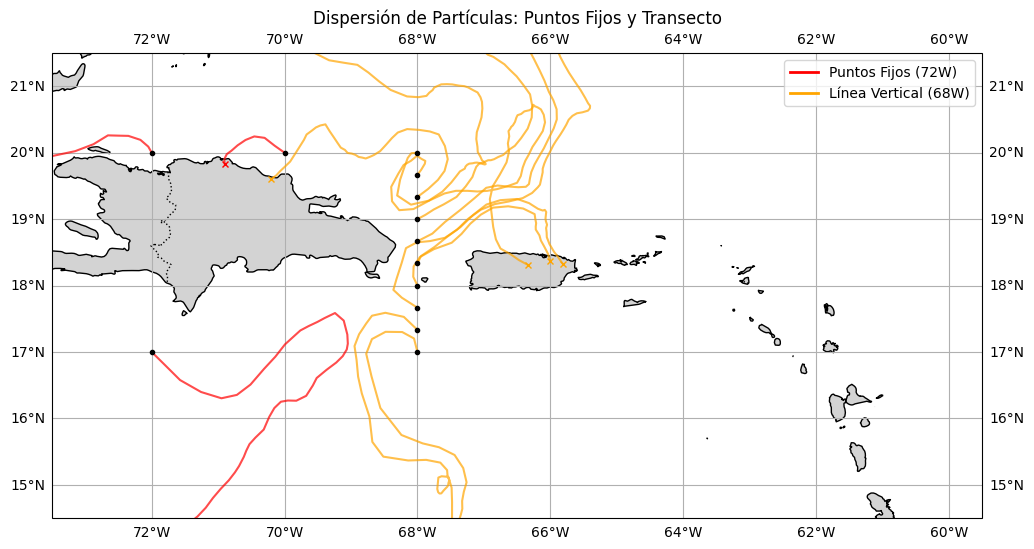

In [ ]:
# ---------------------------------------------------------
# 4. GRAFICAR RESULTADOS
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-73.5, -59.5, 14.5, 21.5], crs=ccrs.PlateCarree())

# Mapa base
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Dibujar trayectorias
for p in particulas:
    # Línea de trayectoria
    ax.plot(p["lon_history"], p["lat_history"], 
            color=p["color"], linewidth=1.5, alpha=0.7, 
            transform=ccrs.PlateCarree())
    
    # Punto de inicio
    ax.plot(p["lon_history"][0], p["lat_history"][0], 
            marker='o', color='black', markersize=3, 
            transform=ccrs.PlateCarree())
    
    # Punto final (flecha o X)
    ax.plot(p["lon_history"][-1], p["lat_history"][-1], 
            marker='x', color=p["color"], markersize=5, 
            transform=ccrs.PlateCarree())

# Truco para la leyenda personalizada (evitar 12 entradas iguales)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax.legend(custom_lines, ['Puntos Fijos', 'Línea Vertical (68W)'], loc='upper right')

plt.title("Dispersión de Partículas: Puntos Fijos y Transecto")
plt.show()

In [37]:
import requests
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---------------------------------------------------------
# 5. FUNCIÓN DE DESCARGA ROBUSTA (Chunked Download)
# ---------------------------------------------------------
def descargar_mdt_seguro(filename="MDT_Caribe_Riesgo.nc"):
    print(f"Iniciando descarga segura de: {filename}")
    # URL corregida y simplificada del servidor NOAA ERDDAP
    # Solicitamos ETOPO1 (Bedrock), recortado a tu zona exacta
    url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(14):1:(21)][(-73):1:(-59)]"
    
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            downloaded = 0
            
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded += len(chunk)
                    # Barra de progreso simple
                    if total_size > 0:
                        percent = (downloaded / total_size) * 100
                        print(f"Descargando: {percent:.1f}%", end='\r')
                        
        print(f"\n¡Descarga completada! Guardado en {filename}")
        return True
    except Exception as e:
        print(f"\nError fatal en descarga: {e}")
        return False

# Ejecutar descarga si no existe el archivo
import os
if not os.path.exists("MDT_Caribe_Riesgo.nc"):
    exito = descargar_mdt_seguro()
else:
    print("El archivo MDT ya existe. Saltando descarga.")
    exito = True



El archivo MDT ya existe. Saltando descarga.


In [38]:
# ---------------------------------------------------------
# 2. CÁLCULO DE OLEAJE (Tu lógica solicitada)
# ---------------------------------------------------------
print("\n--- Estadísticas de Oleaje ---")
ds_waves = xr.open_dataset("AlturaOla.nc")
vhm0 = ds_waves['VHM0']

# Día de mayor altura
max_val = vhm0.max().values
max_point = vhm0.where(vhm0 == max_val, drop=True)
fecha_maxima = pd.to_datetime(max_point.time.values[0])
print(f"Mayor altura significativa: {max_val:.2f}m el día {fecha_maxima}")

# Promedio del 30% superior
vals = vhm0.values.flatten()
vals = vals[~np.isnan(vals)] # Quitar NaNs
vals_sorted = np.sort(vals)[::-1] # Ordenar descendente
top_30_idx = int(len(vals_sorted) * 0.30)
avg_top_30 = np.mean(vals_sorted[:top_30_idx])
print(f"Promedio del 30% de olas más altas: {avg_top_30:.2f}m")




--- Estadísticas de Oleaje ---
Mayor altura significativa: 9.43m el día 2025-08-17 09:00:00
Promedio del 30% de olas más altas: 2.51m


Usando la Altura de Ola Significativa (Top 30%) calculada: 2.51 metros
Cota de inundación definida (Ola + Marea): 3.01 m sobre el nivel del mar
Evaluando topografía en puntos de llegada...
Análisis completado: 0 zonas de riesgo detectadas.


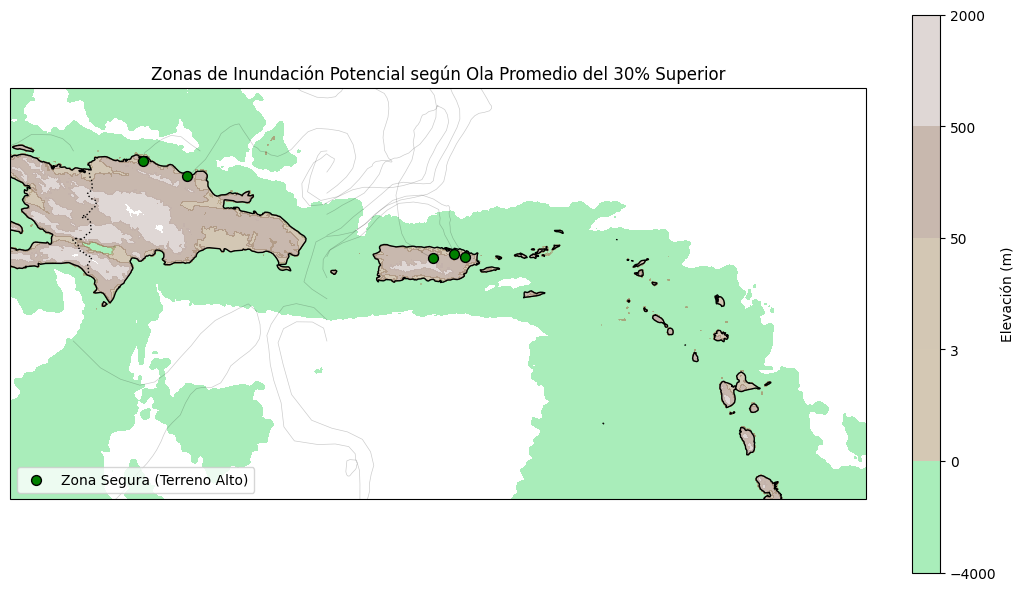

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr

# ---------------------------------------------------------
# 1. DEFINICIÓN DEL UMBRAL DE INUNDACIÓN
# ---------------------------------------------------------
# Recuperamos la variable calculada en el paso 2 del código original.
# Si por alguna razón reiniciaste, pon un valor manual aquí (ej: 2.5 metros)
try:
    umbral_ola = avg_top_30
    print(f"Usando la Altura de Ola Significativa (Top 30%) calculada: {umbral_ola:.2f} metros")
except NameError:
    umbral_ola = 1 # Valor por defecto si no se encuentra la variable
    print(f"Variable no encontrada. Usando valor simulado: {umbral_ola} metros")

# Margen de seguridad (Marea + Storm Surge)
# Generalmente se suma 0.5m o 1m por la marea astronómica
margen_marea = 0.5 
cota_maxima_agua = umbral_ola + margen_marea

print(f"Cota de inundación definida (Ola + Marea): {cota_maxima_agua:.2f} m sobre el nivel del mar")

# ---------------------------------------------------------
# 2. EVALUACIÓN DE PUNTOS DE IMPACTO
# ---------------------------------------------------------
# Cargar MDT (asegúrate de que el archivo MDT_Caribe_Riesgo.nc existe del paso anterior)
try:
    ds_mdt = xr.open_dataset("MDT_Caribe_Riesgo.nc")
    z_data = ds_mdt['altitude']
except FileNotFoundError:
    print("Error: Ejecuta el bloque anterior para descargar el MDT primero.")
    z_data = None

puntos_inundados = []
puntos_seguros = []

if z_data is not None:
    print("Evaluando topografía en puntos de llegada...")
    
    for p in particulas:
        # Posición final
        lat = p["lat_history"][-1]
        lon = p["lon_history"][-1]
        
        # Obtener elevación del terreno en ese punto
        try:
            elevacion = float(z_data.sel(latitude=lat, longitude=lon, method='nearest').values)
            
            # LÓGICA DE CLASIFICACIÓN
            if elevacion <= 0:
                continue # Quedó en el mar o error de dato
            
            elif elevacion < cota_maxima_agua:
                # El terreno es más bajo que la ola -> INUNDACIÓN
                puntos_inundados.append((lon, lat, elevacion))
                
            else:
                # El terreno es más alto que la ola -> SEGURO
                puntos_seguros.append((lon, lat, elevacion))
                
        except Exception:
            continue

    print(f"Análisis completado: {len(puntos_inundados)} zonas de riesgo detectadas.")

    # ---------------------------------------------------------
    # 3. GRAFICACIÓN DE ZONAS DE INUNDACIÓN
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-73, -59.5, 14.5, 21], crs=ccrs.PlateCarree())

    # Fondo MDT (Terreno)
    niveles = [-4000, 0, cota_maxima_agua, 50, 500, 2000]
    # Mapa de colores personalizado: Azul mar, Rojo Inundación, Verde Seguro, Marrón Montaña
    colores_mapa = ['#d1e5f0', '#ef8a62', '#67a9cf', '#fddbc7', '#b2182b'] 
    
    # Dibujamos contornos del terreno
    mdt_plot = ax.contourf(z_data.longitude, z_data.latitude, z_data, 
                           levels=niveles, cmap='terrain', alpha=0.5,
                           transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # GRAFICAR PUNTOS DE INUNDACIÓN (ROJO)
    if puntos_inundados:
        lons_i, lats_i, elevs_i = zip(*puntos_inundados)
        scatter_flood = ax.scatter(lons_i, lats_i, c='red', s=100, 
                                   edgecolor='black', zorder=10, transform=ccrs.PlateCarree(),
                                   label=f'ZONA INUNDABLE (Z < {cota_maxima_agua:.1f}m)')
        
        # Añadir texto con la altura de ola en el mapa
        plt.text(-62, 20.5, f"Ola de Diseño: {umbral_ola:.2f}m\nInundación < {cota_maxima_agua:.2f}m", 
                 bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # GRAFICAR PUNTOS SEGUROS (VERDE)
    if puntos_seguros:
        lons_s, lats_s, elevs_s = zip(*puntos_seguros)
        ax.scatter(lons_s, lats_s, c='green', s=50, 
                   edgecolor='black', zorder=9, transform=ccrs.PlateCarree(),
                   label='Zona Segura (Terreno Alto)')

    # Dibujar trayectorias sutiles
    for p in particulas:
        ax.plot(p["lon_history"], p["lat_history"], 'k-', linewidth=0.5, alpha=0.2, transform=ccrs.PlateCarree())

    plt.title(f"Zonas de Inundación Potencial según Ola Promedio del 30% Superior")
    plt.legend(loc='lower left')
    plt.colorbar(mdt_plot, ax=ax, label='Elevación (m)', fraction=0.03)
    plt.show()